# Algorithm Tests for Checkers Vision

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_img(img_1, title_1=None, img_2=None, title_2=None):
    if img_2 is not None:
        plt.subplot(121)
    if title_1 is not None:
        plt.title(title_1)
    plt.imshow(img_1, cmap='gray') # cmap is ignored for color images
    if img_2 is not None:
        plt.subplot(122)
        if title_2 is not None:
            plt.title(title_2)
        plt.imshow(img_2, cmap='gray')
        
    plt.show()

## Load Image

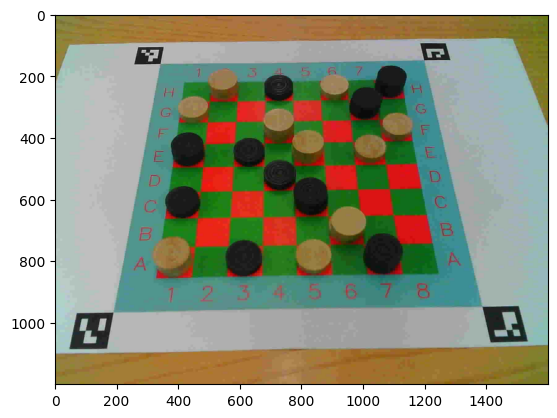

In [3]:
img = cv2.imread('../resources/full-board.jpg', cv2.IMREAD_COLOR_RGB)
#img = cv2.imread('../resources/whites3.jpg', cv2.IMREAD_COLOR_RGB)

if img is None:
    print("failed to load the image!")
else:
    show_img(img)

## Extract Board

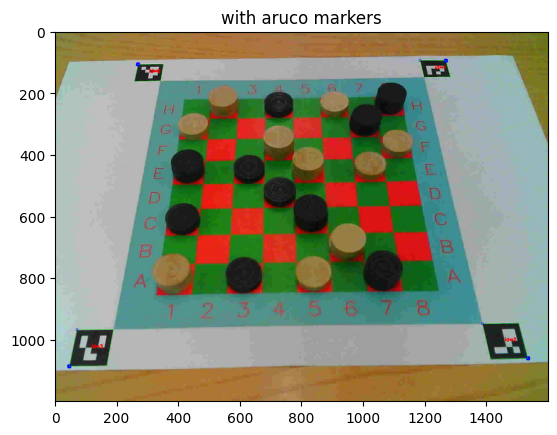

In [4]:
def get_corners(img):
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    parameters = cv2.aruco.DetectorParameters()
    
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejected = detector.detectMarkers(img)
    
    if ids is None:
        print("failed to detect markers, something is wrong!")
        return None

    if len(ids) != 4:
        print("error: expected 4 markers but got %i!" %len(ids))
        print("Detected markers:", ids)
        return None

    chessboard_corners = np.zeros((4,2), dtype=np.int32)
    
    for id_,corner in zip(ids, corners):
        c = corner[0][id_[0]]
        chessboard_corners[id_] = c.astype(np.int32)

    return chessboard_corners, (ids, corners)

chessboard_corners, corners_dbg = get_corners(img)
result = img.copy()
for c in chessboard_corners:
    cv2.circle(result,c,2,(0,0,255),10)

cv2.aruco.drawDetectedMarkers(result, corners_dbg[1], corners_dbg[0])
show_img(result, 'with aruco markers')

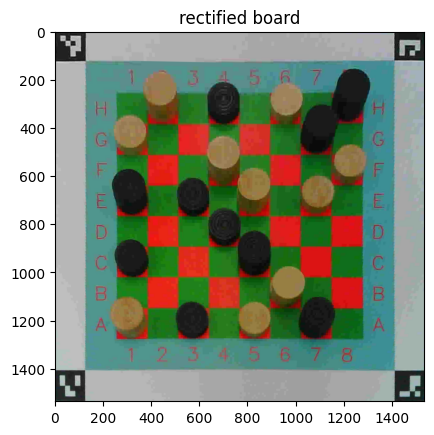

In [5]:
num_fields = 8
num_columns_total = num_fields + 4
field_height = 128
l = field_height * num_columns_total
img_size = np.array([l,l]).astype(np.uint32)

# OLD (but maybe still better now with the new position?)
#we start with ID 1 at the bottom left and go clockwise
#dst_corners = np.array([
#    [l, l],
#    [0, l],
#    [0, 0],
#    [l, 0],
#]).astype(np.int32)
# NEW
# we start with ID 1 at the bottom left and go clockwise
dst_corners = np.array([
    [0, 0],
    [l, 0],
    [l, l],
    [0, l],
]).astype(np.int32)

H = cv2.findHomography(chessboard_corners, dst_corners)
board = cv2.warpPerspective(img, H[0], img_size)
board_hsv = cv2.cvtColor(board, cv2.COLOR_RGB2HSV)
show_img(board, 'rectified board')

## Chess Grid

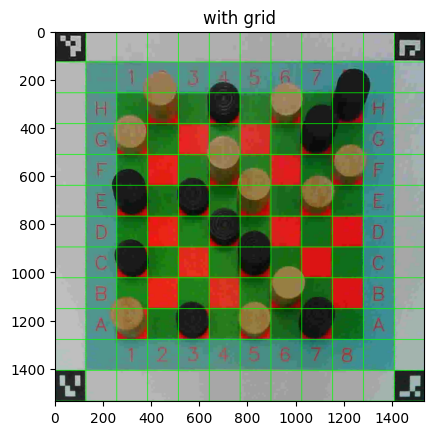

In [6]:
def add_chess_grid(img):
    result = img.copy()

    for row in range(num_columns_total+1):
        cv2.line(result, (0, row*field_height), (result.shape[0], row*field_height), (0,255,0), 2)
    
    for col in range(num_columns_total+1):
        cv2.line(result, (col*field_height, 0), (col*field_height, result.shape[1]), (0,255,0), 2)
    
    return result

show_img(add_chess_grid(board), 'with grid')

### Color Segmentation
[HSV Color Space](https://i.sstatic.net/gyuw4.png)

In [7]:
def get_mask_for_board_area(img):
    mask = np.zeros_like(img)
    mask[2*field_height:l-2*field_height,2*field_height:l-2*field_height] = 255
    return mask
def get_extended_mask_for_board_area(img):
    mask = np.zeros_like(img)
    mask[field_height:l-field_height,field_height:l-field_height] = 255
    return mask

def get_mask_for_color(img_hsv, lowerb, upperb, do_morph=False):
    mask = np.zeros_like(img_hsv)
    mask[np.where(cv2.inRange(img_hsv, lowerb, upperb))] = 255
    if do_morph:
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (10,10)))
    return mask

### Blacks

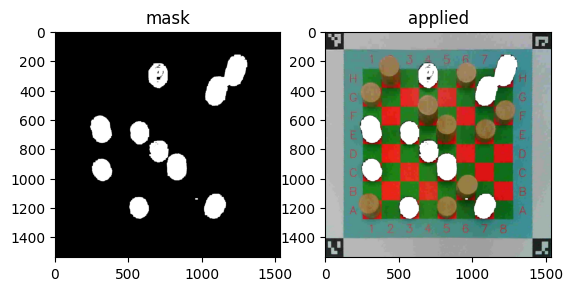

In [8]:
mask_blacks = get_mask_for_color(board_hsv, np.array([0, 0, 0]), np.array([180, 255, 50]), True)
mask_blacks = cv2.bitwise_and(mask_blacks, get_extended_mask_for_board_area(board))
show_img(mask_blacks, 'mask', cv2.add(board, mask_blacks), 'applied')

### Whites
**TODO**

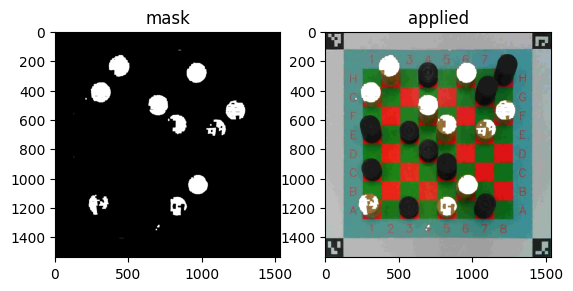

In [9]:
#mask_whites = get_mask_for_color(board_hsv, np.array([0, 0, 100]), np.array([50, 200, 255]), True)
mask_whites = get_mask_for_color(board_hsv, np.array([0, 0, 100]), np.array([50, 150, 255]), True)
mask_whites = cv2.bitwise_and(mask_whites, get_extended_mask_for_board_area(board))
show_img(mask_whites, 'mask', cv2.add(board, mask_whites), 'applied')

### Reds
**TODO**

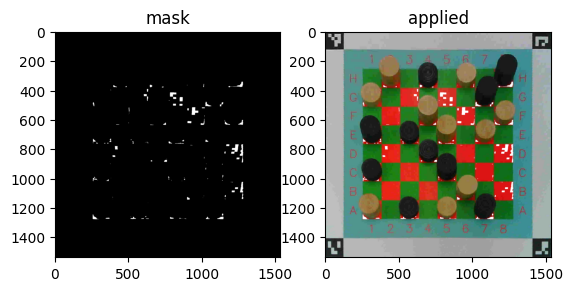

In [10]:
# OpenCV uses 0..180° where red = 0/180. see: https://i.sstatic.net/gyuw4.png
mask_reds = get_mask_for_color(board_hsv, np.array([170, 100, 100]), np.array([180, 255, 255]))
cv2.add(mask_reds, get_mask_for_color(board_hsv, np.array([0, 100, 100]), np.array([20, 255, 255])))
mask_reds = cv2.bitwise_and(mask_reds, get_mask_for_board_area(board))
show_img(mask_reds, 'mask', cv2.add(board, mask_reds), 'applied')

### Greens

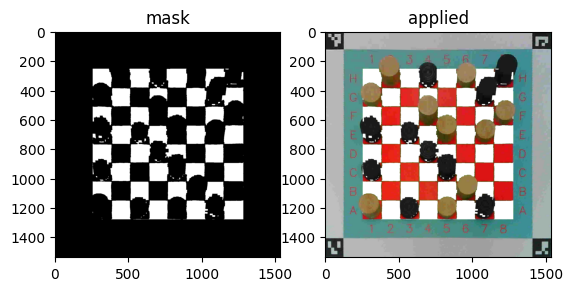

In [11]:
mask_greens = get_mask_for_color(board_hsv , np.array([40, 50, 0]), np.array([90, 255, 255]))
mask_greens = cv2.bitwise_and(mask_greens, get_mask_for_board_area(board))
show_img(mask_greens, 'mask', cv2.add(board, mask_greens), 'applied')

### Board Fields

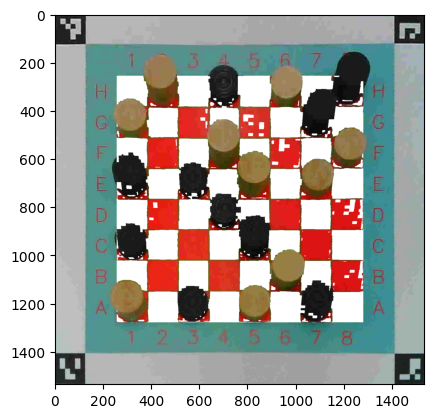

In [12]:
show_img(cv2.add(board, cv2.add(mask_greens, mask_reds)))

### Stones

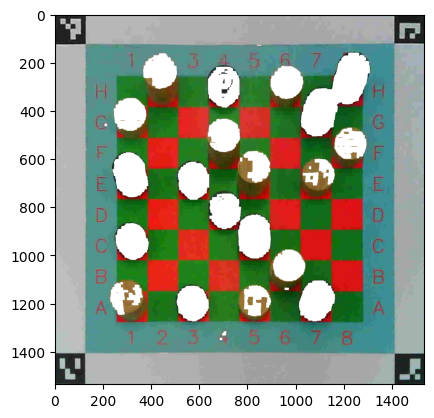

In [13]:
show_img(cv2.add(board, cv2.add(mask_whites, mask_blacks)))

### Leftovers

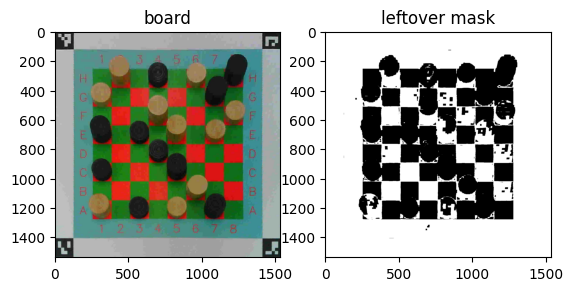

In [14]:
show_img(board, 'board', cv2.subtract(np.ones_like(board)*255, cv2.add(mask_blacks, cv2.add(mask_reds, cv2.add(mask_greens, mask_whites)))), 'leftover mask')

## Occupancy Check

blacks = -1, whites = 1, +/-2 = king, 0 = unoccupied, 9 = white squares
[[ 9  1  9 -1  9  1  9 -2]
 [ 1  9  0  9  0  9 -2  9]
 [ 9  0  9  1  9  0  9  1]
 [-2  9 -1  9  1  9  0  9]
 [ 9  0  9 -1  9  0  9  0]
 [-1  9  0  9 -2  9  0  9]
 [ 9  0  9  0  9  1  9  0]
 [ 0  9 -1  9  1  9 -2  9]]


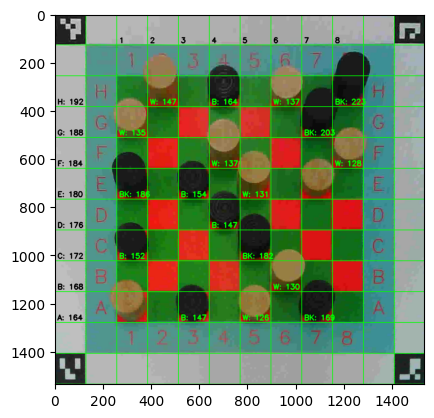

In [15]:
px_per_field = field_height*field_height

occupancy = np.ones((num_fields, num_fields), dtype=np.int8) * 9

result = add_chess_grid(board)

def get_mask(mask, col, row):
    return mask[field_height*(row-1):field_height*(row+1),field_height*col:field_height*(col+1),0]

def get_contour_height(mask, col, row):
    contours, hierarchy = cv2.findContours(get_mask(mask, col, row), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    found_contour = False
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 5000:
            if found_contour:
                raise RuntimeError('error: found a second large contour in the same field (%i,%i) - that should never be the case!' %(col-1,row-1))
            found_contour = True
            return np.max(contour[:,:,1]) - np.min(contour[:,:,1])
    raise RuntimeError('failed to find a contour which is large enough in field (%i,%i)!' %(col-1,row-1))

# magic guesstimate!
king_treshold_diff_per_field = 4
king_treshold_height = 160 + king_treshold_diff_per_field*num_fields

for col in range(2, num_fields+2):
    cv2.putText(result, "%s" %chr(ord('1') + col - 2), (field_height*col+10,(field_height+1)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
    for row in range(2 + (1 if col%2==0 else 0), num_fields + 2, 2):
        current_king_treshold_height = king_treshold_height - king_treshold_diff_per_field*(row-2)
        if col <= 3: # do it only once
            cv2.putText(result, "%s: %i" %(chr(ord('H') - row + 2), current_king_treshold_height), (10,field_height*(row+1)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
        
        occupancy_whites = np.count_nonzero(get_mask(mask_whites, col, row)) / px_per_field
        occupancy_blacks = np.count_nonzero(get_mask(mask_blacks, col, row)) / px_per_field
        # debug: show_img(get_mask(mask_whites, col, row), 'whites (%i,%i): %.3f' %(col,row,occupancy_whites), get_mask(mask_blacks, col, row), 'blacks (%i,%i): %.3f' %(col,row,occupancy_blacks))

        color = 0 # free
        tmp_mask = np.array([])
        if occupancy_whites > 0.5:
            color = 1 # white
            tmp_mask = mask_whites
        elif occupancy_blacks > 0.5:
            color = -1 # black
            tmp_mask = mask_blacks

        if color != 0:
            try:
                height = get_contour_height(tmp_mask, col, row)
                if height > current_king_treshold_height:
                    color *= 2
    
                color_text='W' if color>0 else 'B'
                maybe_king='K' if height>current_king_treshold_height else ''
                cv2.putText(result, "%s%s: %i" %(color_text, maybe_king, height), (field_height*col+10,field_height*(row+1)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
            except Exception as e:
                print('failed to handle %s figure on field (%i,%i):' %('white' if color>0 else 'black', col-1,row-1), e)

        occupancy[row-2, col-2] = color

print('blacks = -1, whites = 1, +/-2 = king, 0 = unoccupied, 9 = white squares')
print(occupancy)

plt.imshow(result)
plt.show()